In [1]:
### Load EDA pkgs
import pandas as pd
import numpy as np

### Data Viz Pkgs
import matplotlib.pyplot as plt
import seaborn as sns

### Feature selection
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier
## Model pkgs
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import cv
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
### Load dataset
df = pd.read_csv('./copd_data.csv')
df.head(2)

,subject_id,# of admissions,# of ICU stays,with DM,Age,Sex,CAD,HTN,CKD,Cancer,...,LACTATE,CREAT,Elixhausr,ICU Admission(length of stay ),Hospital Mortality,Renal replacement therapy,Failure,Weight,Height,BMI
0,29156,1,1,0,72,M,0,0,0,0,...,0.9,0.4,0.0,10,1,0,0,60.8,1.60,23.0
1,31288,1,1,0,90,F,1,1,0,0,...,0.9,0.5,0.0,1,0,0,0,80.0,1.73,26.0


In [3]:
#### make all column names lower and replace space with underscore
df.columns = df.columns.str.lower().str.replace(' ', '_')

#### convert sex to 1 or 0 for M or F so that we have numeric values
df['sex'] = df['sex'].replace(['M','F'],[1, 0])

#### Rename ICU admision Length of stay
df.rename(columns = {'icu_admission(length_of_stay_)':'icu_admission(los)'}, inplace = True)


<AxesSubplot:>

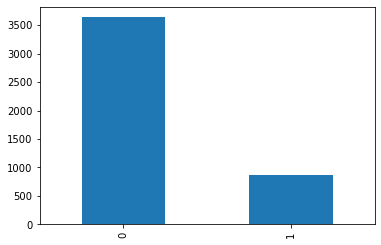

In [4]:
df['hospital_mortality'].value_counts().plot(kind='bar')

In [5]:
df.columns

Index(['subject_id', '#_of_admissions', '#_of_icu_stays', 'with_dm', 'age',
       'sex', 'cad', 'htn', 'ckd', 'cancer', 'hba1c', 'fpg', 'd1_spo2',
       'd1_sbp', 'd2_paw', 'd2_maps', 'wbc', 'neut', 'lactate', 'creat',
       'elixhausr', 'icu_admission(los)', 'hospital_mortality',
       'renal_replacement_therapy', 'failure', 'weight', 'height', 'bmi'],
      dtype='object')

<AxesSubplot:>

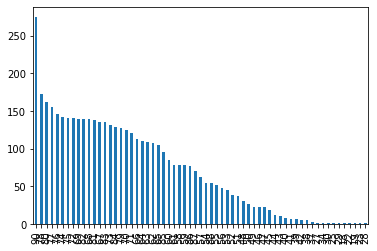

In [6]:
df['age'].value_counts().plot(kind='bar')

<AxesSubplot:>

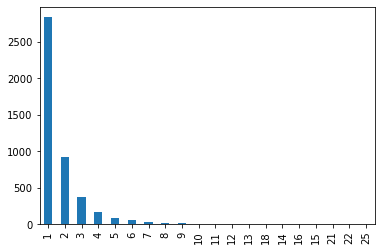

In [7]:
df['#_of_icu_stays'].value_counts().plot(kind='bar')

In [8]:
### Age range
df.groupby(['sex','age']).size()
labels = ["< 20","20-30","30-40","40-50","50-60","60-70","70-80","80 >"]
bins= [0,20,30,40,50,60,70,80,90]
freq_df = df.groupby(pd.cut(df['age'],bins=bins,labels=labels)).size()
freq_df = freq_df.reset_index(name='count')
freq_df

,age,count
0,< 20,2
1,20-30,8
2,30-40,26
3,40-50,178
4,50-60,579
5,60-70,1164
6,70-80,1441
7,80 >,1113


<AxesSubplot:>

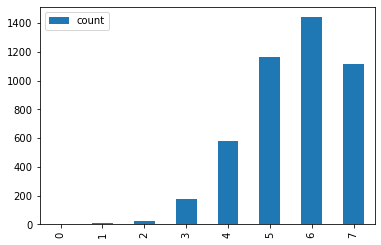

In [9]:
freq_df.plot(kind='bar')

In [10]:
out = df[df['height'] ==0]
median = df.loc[df['height']<2.3, 'height'].median()

df["height"] = np.where(df["height"] >2.3, median,df['height'])
df["height"] = np.where(df["height"] ==0, median,df['height'])


C:\Users\_\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='height'>

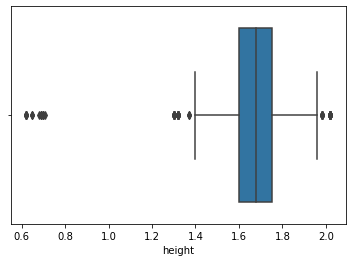

In [11]:
sns.boxplot(df['height'])

In [12]:
bmi_median = df.loc[df['bmi']<60, 'bmi'].median()

df["bmi"] = np.where(df["bmi"] >60, bmi_median,df['bmi'])

C:\Users\_\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='bmi'>

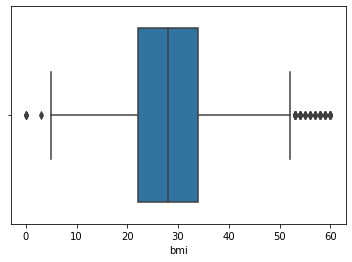

In [13]:
sns.boxplot(df['bmi'])

In [14]:
df.columns

Index(['subject_id', '#_of_admissions', '#_of_icu_stays', 'with_dm', 'age',
       'sex', 'cad', 'htn', 'ckd', 'cancer', 'hba1c', 'fpg', 'd1_spo2',
       'd1_sbp', 'd2_paw', 'd2_maps', 'wbc', 'neut', 'lactate', 'creat',
       'elixhausr', 'icu_admission(los)', 'hospital_mortality',
       'renal_replacement_therapy', 'failure', 'weight', 'height', 'bmi'],
      dtype='object')

In [19]:
xfeatures = df[['#_of_admissions', '#_of_icu_stays', 'with_dm', 'age','sex', 'cad', 'htn', 'ckd', 'cancer', 
                'hba1c', 'fpg', 'd1_spo2','d1_sbp', 'd2_paw', 'd2_maps', 'wbc', 'neut', 'lactate', 'creat',
                'elixhausr', 'icu_admission(los)','renal_replacement_therapy', 'failure', 'weight', 'height', 'bmi']]
ylabels = df['hospital_mortality']

<AxesSubplot:xlabel='age', ylabel='icu_admission(los)'>

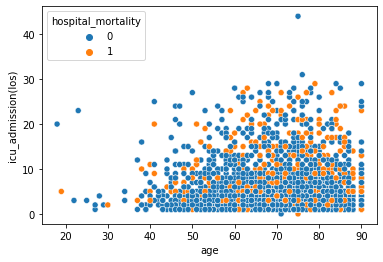

In [27]:
sns.scatterplot(data=df,x='age', y='icu_admission(los)', hue='hospital_mortality')

In [28]:
xfeatures = df[['#_of_admissions', '#_of_icu_stays','age', 'cad', 'htn', 'ckd', 'cancer', 
                'hba1c', 'fpg', 'd1_spo2','d1_sbp', 'wbc', 'neut', 'creat',
                 'icu_admission(los)', 'failure', 'weight']]
ylabels = df['hospital_mortality']

In [47]:
x_train, x_test, y_train, y_test = train_test_split(xfeatures, ylabels, test_size = 0.3, random_state = 0)

In [48]:
clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)
clf.score(x_test,y_test)

0.7119645494830132

In [49]:
# knn
knn = KNeighborsClassifier()
knn.fit(x_train,y_train)
knn.score(x_test, y_test)


0.7843426883308715

In [50]:
logit = LogisticRegression(max_iter=5000, class_weight='balanced',penalty='l2')
logit.fit(x_train,y_train)
logit.score(x_test,y_test)

0.6336779911373708

In [51]:
logit.predict(np.array(x_test.values[0]).reshape(1,-1))

array([0], dtype=int64)

In [52]:
rnf = RandomForestClassifier(random_state=0, n_jobs=-1, class_weight="balanced")
rnf.fit(x_train,y_train)
rnf.score(x_test,y_test)

0.810192023633678

In [53]:
def CreateBalancedSampleWeights(y_train, largest_class_weight_coef):
    classes = np.unique(y_train, axis = 0)
    classes.sort()
    class_samples = np.bincount(y_train)
    total_samples = class_samples.sum()
    n_classes = len(class_samples)
    weights = total_samples / (n_classes * class_samples * 1.0)
    class_weight_dict = {key : value for (key, value) in zip(classes, weights)}
    class_weight_dict[classes[1]] = class_weight_dict[classes[1]] * largest_class_weight_coef
    sample_weights = [class_weight_dict[y] for y in y_train]
    return sample_weights

In [54]:
largest_class_weight_coef = max(df['hospital_mortality'].value_counts().values)/df.shape[0]
    
#pass y_train as numpy array
weight = CreateBalancedSampleWeights(y_train, largest_class_weight_coef)

In [55]:
# define data_dmatrix
data_dmatrix = xgb.DMatrix(data=xfeatures,label=ylabels)


In [56]:
### declare parameters
params ={'objective':'binary:logistic',
         'max_depth': 4,
         'alpha': 10,
         'learning_rate' : 1.0,
         'n_estimators':100
         }

In [57]:
# instantiate the classfier
xgb_clf = XGBClassifier(learning_rate =0.001,
n_estimators=1000,
weights = weight,
max_depth=18,
min_child_weight=10,
)

## Training XGBoost to the training set
xgb_clf.fit(x_train,y_train)

### score
xgb_clf.score(x_test,y_test)

[11:00:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { weights } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




0.8138847858197932

In [58]:
# making predictions on the test data and confusion matrix
y_pred = xgb_clf.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
print(cm)
print('Model Accuracy Score:', accuracy_score(y_test,y_pred))

[[1096    4]
 [ 248    6]]
Model Accuracy Score: 0.8138847858197932


In [59]:
### Applying the K-Fold Cross Validation for XGBoost
from xgboost import cv
from sklearn.model_selection import cross_val_score

########
accuracies = cross_val_score(estimator= xgb_clf, X=x_train,y=y_train,cv=10)
print('Accuracy:{:.2f} %'.format(accuracies.mean()*100))
print("Standard Deviation:{:.2f} %".format(accuracies.std()*100))

[11:01:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { weights } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:01:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { weights } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:01:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { weights } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

In [60]:
# CatBoost
from catboost import CatBoostClassifier
catboost = CatBoostClassifier()
catboost.fit(x_train,y_train)
catboost.score(x_test,y_test)

Learning rate set to 0.016832
0:	learn: 0.6857203	total: 159ms	remaining: 2m 39s
1:	learn: 0.6785718	total: 169ms	remaining: 1m 24s
2:	learn: 0.6718502	total: 178ms	remaining: 59s
3:	learn: 0.6646567	total: 191ms	remaining: 47.6s
4:	learn: 0.6579230	total: 201ms	remaining: 40s
5:	learn: 0.6514111	total: 223ms	remaining: 36.9s
6:	learn: 0.6452841	total: 227ms	remaining: 32.3s
7:	learn: 0.6393074	total: 232ms	remaining: 28.8s
8:	learn: 0.6336735	total: 236ms	remaining: 26s
9:	learn: 0.6281312	total: 240ms	remaining: 23.7s
10:	learn: 0.6228167	total: 243ms	remaining: 21.9s
11:	learn: 0.6173567	total: 247ms	remaining: 20.3s
12:	learn: 0.6120997	total: 251ms	remaining: 19s
13:	learn: 0.6072136	total: 254ms	remaining: 17.9s
14:	learn: 0.6023483	total: 258ms	remaining: 16.9s
15:	learn: 0.5977632	total: 261ms	remaining: 16.1s
16:	learn: 0.5926583	total: 265ms	remaining: 15.3s
17:	learn: 0.5887492	total: 269ms	remaining: 14.7s
18:	learn: 0.5845673	total: 273ms	remaining: 14.1s
19:	learn: 0.5808

0.8094534711964549

In [61]:
y_predCat = catboost.predict(x_test)
cm = confusion_matrix(y_test, y_predCat)
print(cm)
accuracy_score(y_test,y_predCat)

[[1090   10]
 [ 248    6]]


0.8094534711964549

In [62]:
import shap

In [63]:
shap.initjs()

In [64]:
## shap_values
explainer = shap.TreeExplainer(xgb_clf,x_train)
shap_values = explainer.shap_values(x_test)

 99%|===================| 1343/1354 [01:32<00:00]        

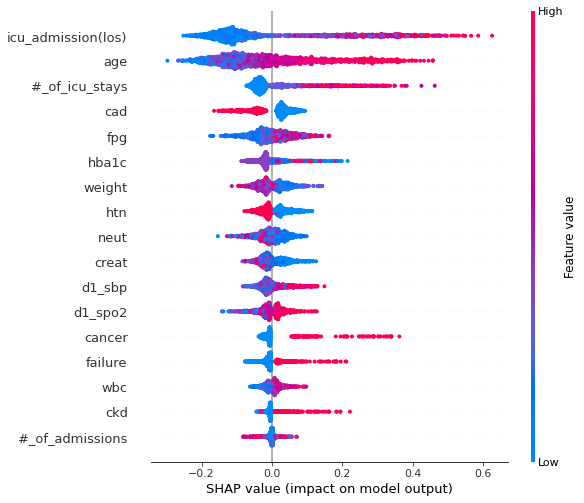

In [65]:
shap.summary_plot(shap_values,x_test)